# Welcome to Time Series! #

**Forecasting** is perhaps the most common application of machine learning in the real world. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. The understanding of things to come is a pressing need across science, government, and industry (not to mention our personal lives!), and practitioners in these fields are increasingly applying machine learning to address this need.

Time series forecasting is a broad field with a long history. This course focuses on the application of modern machine learning methods to time series data with the goal of producing the most accurate predictions. The lessons in this course were inspired by winning solutions from past Kaggle forecasting competitions but will be applicable whenever accurate forecasts are a priority.

After finishing this course, you'll know how to:
- engineer features to model the major time series components (*trends*, *seasons*, and *cycles*),
- visualize time series with many kinds of *time series plots*,
- create forecasting *hybrids* that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

As part of the exercises, you'll get a chance to participate in our [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781) Getting Started competition. In this competition, you're tasked with forecasting sales for *Corporación Favorita* (a large Ecuadorian-based grocery retailer) in almost 1800 product categories.

# What is a Time Series? #

The basic object of forecasting is the **time series**, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

 1、本案例中使用lag1，也就是偏移一个单位，说白了就是今天的销售额取决于昨天的销售额，因此是简单的
    线性关系，通过后续的图示可以看出时线性增长的，原因就在这，训练出一个正的权重来就是单调递增
    
    2、如果说变成长时间依赖或者数据之间的关系是复杂的非线性，那么线性模型就失效了，此时应该考虑其他的
    更加复杂的机器学习方法

    3、 lag1表示前后一天的数据，lag7则表示一个星期以前的数据，lag365则表示一年前的数据，处理周期
    型数据可能就不适用了，这个时候就考虑第二节 - trend

In [47]:

import pandas as pd

df = pd.read_csv(
    "../input/ts-course-data/book_sales.csv",
    # 指定Date为索引列，用来标识每行数据
    index_col='Date',
    # 将Date这一列数据转换成为date的格式
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations `Hardcover` with a time index `Date`.

# Linear Regression with Time Series #

For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The **linear regression** algorithm learns how to make a weighted sum from its input features. For two features, we would have:

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

During training, the regression algorithm learns values for the parameters `weight_1`, `weight_2`, and `bias` that best fit the `target`. (This algorithm is often called *ordinary least squares* since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called *regression coefficients* and the `bias` is also called the *intercept* because it tells you where the graph of this function crosses the y-axis.

### Time-step features

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

In [48]:

import numpy as np
# 创建一列Time，值就是顺序下来的
df['Time'] = np.arange(len(df.index))
# 读入数据的时候指定的索引为Date
print(df.index)
df.head()

DatetimeIndex(['2000-04-01', '2000-04-02', '2000-04-03', '2000-04-04',
               '2000-04-05', '2000-04-06', '2000-04-07', '2000-04-08',
               '2000-04-09', '2000-04-10', '2000-04-11', '2000-04-12',
               '2000-04-13', '2000-04-14', '2000-04-15', '2000-04-16',
               '2000-04-17', '2000-04-18', '2000-04-19', '2000-04-20',
               '2000-04-21', '2000-04-22', '2000-04-23', '2000-04-24',
               '2000-04-25', '2000-04-26', '2000-04-27', '2000-04-28',
               '2000-04-29', '2000-04-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Linear regression with the time dummy produces the model:

```
target = weight * time + bias
```

The time dummy then lets us fit curves to time series in a *time plot*, where `Time` forms the x-axis.

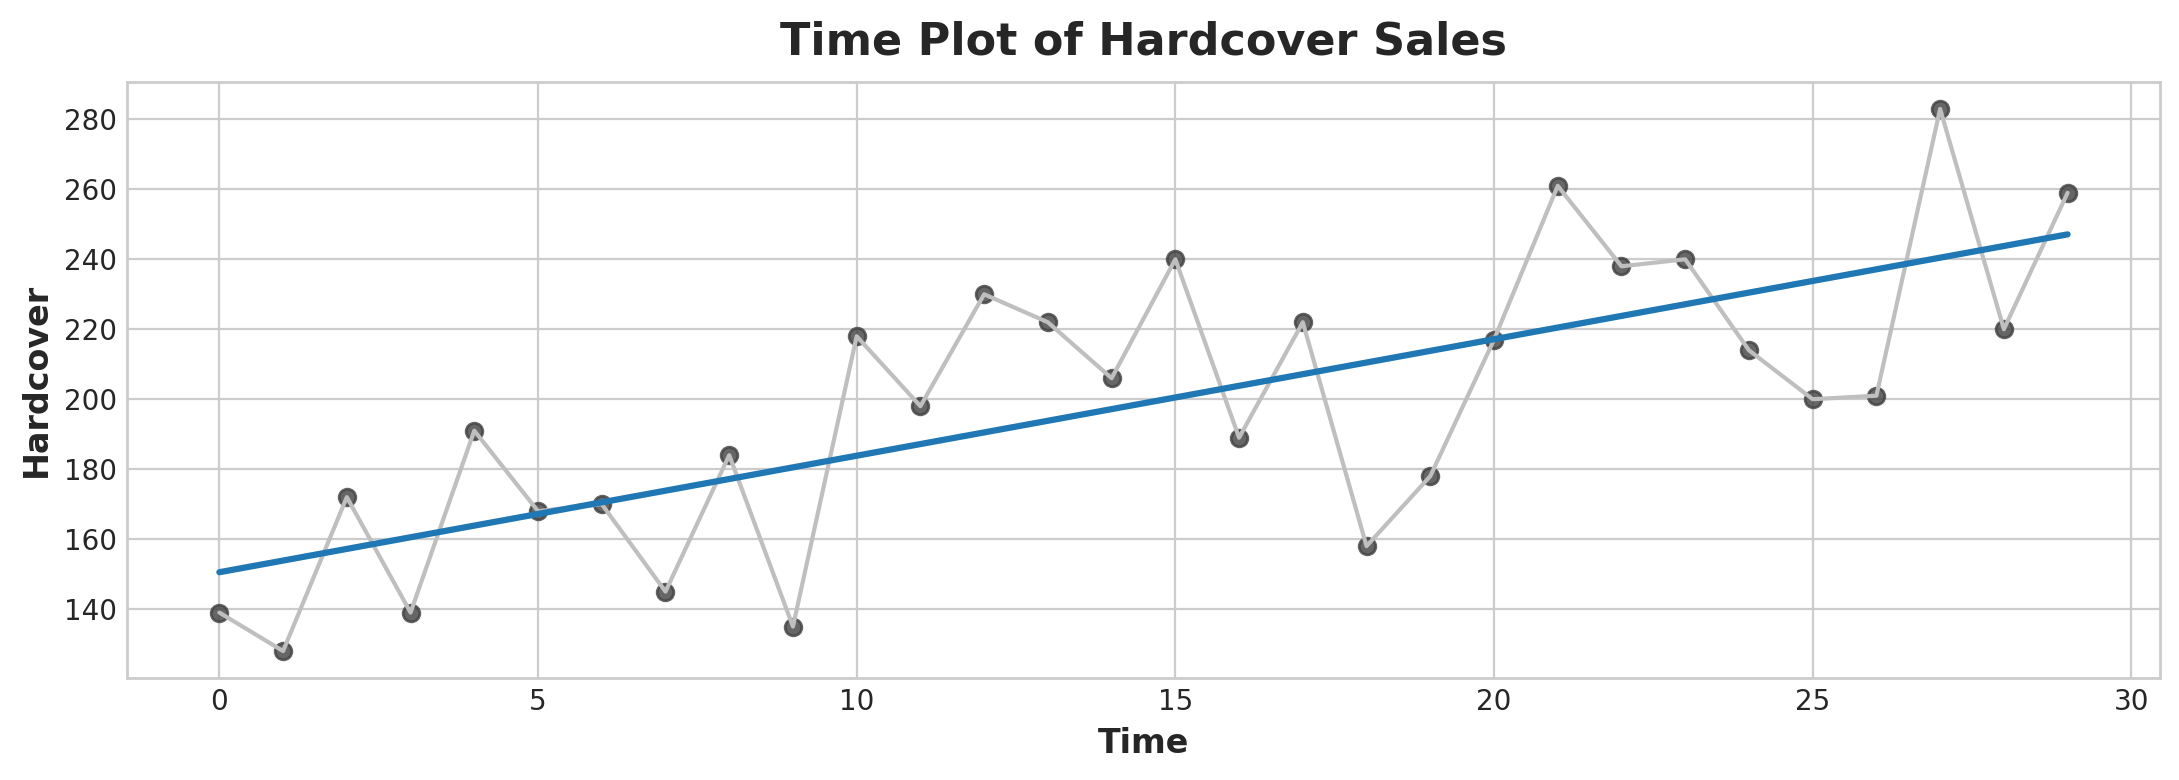

In [49]:

import matplotlib.pyplot as plt
import seaborn as sns
# 设置图标样式为seaborn库中的白色背景和灰色网格线
plt.style.use("seaborn-whitegrid")
# 自定义图表figure和轴axes的属性
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
# 魔法命令，提高分辨率
%config InlineBackend.figure_format = 'retina'
# 总体目标 - 绘制时间和Hardcover的折现和回归线，对应真实值和预测值
# 图表和轴对象
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
# 绘制一个回归线
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. In the *Hardcover Sales* series, we can predict that sales later in the month are generally higher than sales earlier in the month.

### Lag features

To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [50]:

df['Lag_1'] = df['Hardcover'].shift(1)
# lag1-滞后一天，4.2的数据是4.1的，4.3的数据是4.2的，也就是预测4.3真实值使用的是4.2的数据，避免了未来数据的干扰
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model:

```
target = weight * lag + bias
```

So lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation.

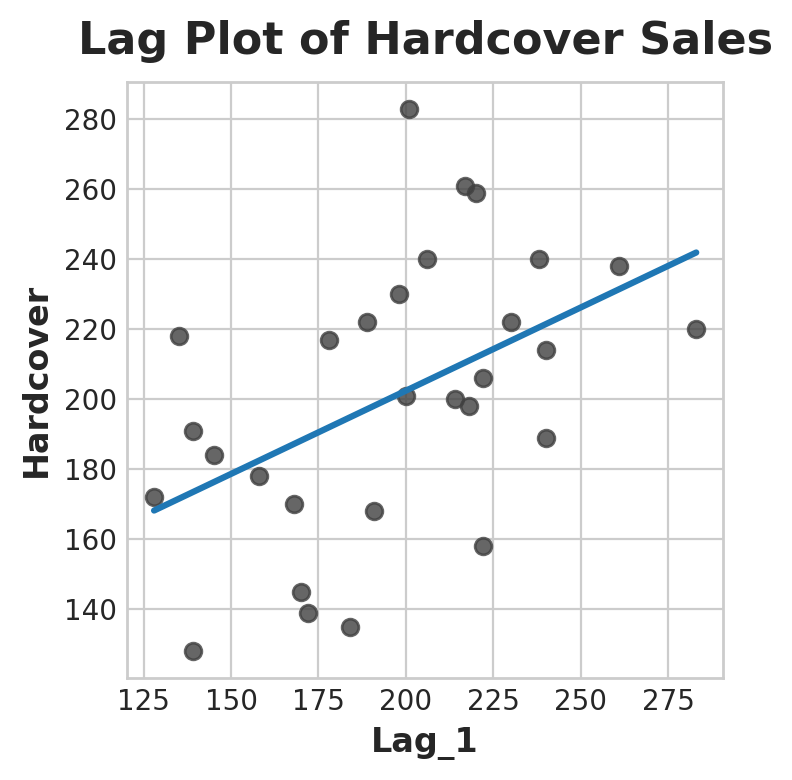

In [51]:

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day (`Hardcover`) are correlated with sales from the previous day (`Lag_1`). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations. In *Hardcover Sales*, we can predict that high sales on one day usually mean high sales the next day.

---

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For most of the course, we use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

# Example - Tunnel Traffic #

*Tunnel Traffic* is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.

The hidden cell sets everything up.

In [52]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
print(tunnel)
# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
# 在pandas中DatetimeIndex是代表瞬间的时间点，而PeriodIndex代表的是一个具体的时间段，比如说一天，而不是某个具体的时间点
# 如果在一天中有多个时间节点，预处理的时候可能需要先聚合数据，然后再转成period
tunnel = tunnel.to_period()

tunnel.head()

           Day  NumVehicles
0   2003-11-01       103536
1   2003-11-02        92051
2   2003-11-03       100795
3   2003-11-04       102352
4   2003-11-05       106569
..         ...          ...
742 2005-11-12       104646
743 2005-11-13        94424
744 2005-11-14       112165
745 2005-11-15       114296
746 2005-11-16       114690

[747 rows x 2 columns]


,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step feature

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [53]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [54]:
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

In [55]:
X

,Time
Day,
2003-11-01,0
2003-11-02,1
2003-11-03,2
2003-11-04,3
2003-11-05,4
...,...
2005-11-12,742
2005-11-13,743
2005-11-14,744


In [56]:
y

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Freq: D, Name: NumVehicles, Length: 747, dtype: int64

In [57]:
X, y

(            Time
 Day             
 2003-11-01     0
 2003-11-02     1
 2003-11-03     2
 2003-11-04     3
 2003-11-05     4
 ...          ...
 2005-11-12   742
 2005-11-13   743
 2005-11-14   744
 2005-11-15   745
 2005-11-16   746
 
 [747 rows x 1 columns],
 Day
 2003-11-01    103536
 2003-11-02     92051
 2003-11-03    100795
 2003-11-04    102352
 2003-11-05    106569
                ...  
 2005-11-12    104646
 2005-11-13     94424
 2005-11-14    112165
 2005-11-15    114296
 2005-11-16    114690
 Freq: D, Name: NumVehicles, Length: 747, dtype: int64)

In [58]:
from sklearn.linear_model import LinearRegression

# Training data
# X是把时间和所有的Times列截下来，y是把时间和所对应的NumVehicles截下来
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [59]:
X.index

PeriodIndex(['2003-11-01', '2003-11-02', '2003-11-03', '2003-11-04',
             '2003-11-05', '2003-11-06', '2003-11-07', '2003-11-08',
             '2003-11-09', '2003-11-10',
             ...
             '2005-11-07', '2005-11-08', '2005-11-09', '2005-11-10',
             '2005-11-11', '2005-11-12', '2005-11-13', '2005-11-14',
             '2005-11-15', '2005-11-16'],
            dtype='period[D]', name='Day', length=747)

In [60]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

In [61]:
y_pred[:5]

array([98176.20634409, 98198.70379363, 98221.20124316, 98243.69869269,
       98266.19614223])

In [62]:
y_pred = pd.Series(y_pred, index=X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

The model actually created is (approximately): `Vehicles = 22.5 * Time + 98176`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

In [63]:
y

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Freq: D, Name: NumVehicles, Length: 747, dtype: int64

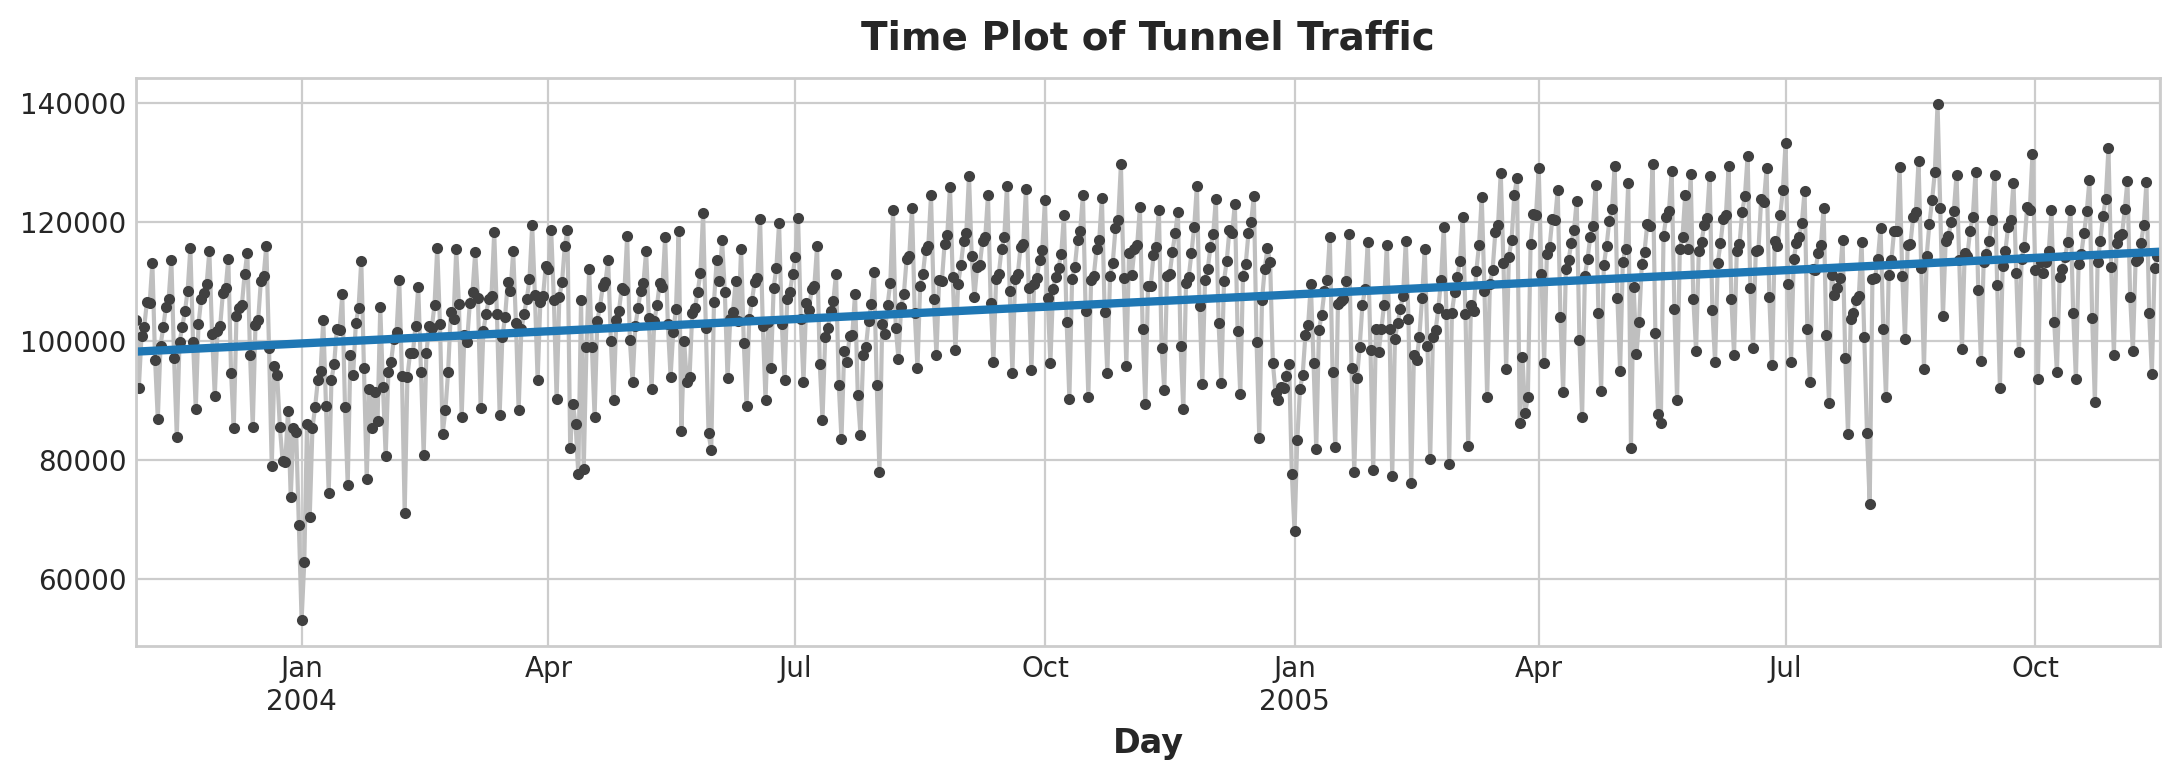

In [64]:

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

Pandas provides us a simple method to lag a series, the `shift` method.

In [65]:
# 额外创建新的lag_1，是通过NumVehicles来滞后一个单位做预测的
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [66]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-02    104961.799284
2003-11-03     98840.684037
2003-11-04    103500.939302
2003-11-05    104330.767464
2003-11-06    106578.285356
                  ...      
2005-11-12    117280.776890
2005-11-13    105553.391615
2005-11-14    100105.412508
2005-11-15    109560.763451
2005-11-16    110696.514134
Freq: D, Length: 746, dtype: float64

In [67]:
from sklearn.linear_model import LinearRegression
X = df.loc[:, ['Lag_1']]
X.fillna(method='backfill', inplace=True)
y = df.loc[:, 'NumVehicles']
y, X = y.align(X, join='inner')
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-01    104959.778420
2003-11-02    104959.778420
2003-11-03     98838.236169
2003-11-04    103498.816530
2003-11-05    104328.702580
                  ...      
2005-11-12    117279.615389
2005-11-13    105551.412020
2005-11-14    100103.052866
2005-11-15    109559.063408
2005-11-16    110694.893319
Freq: D, Length: 747, dtype: float64

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

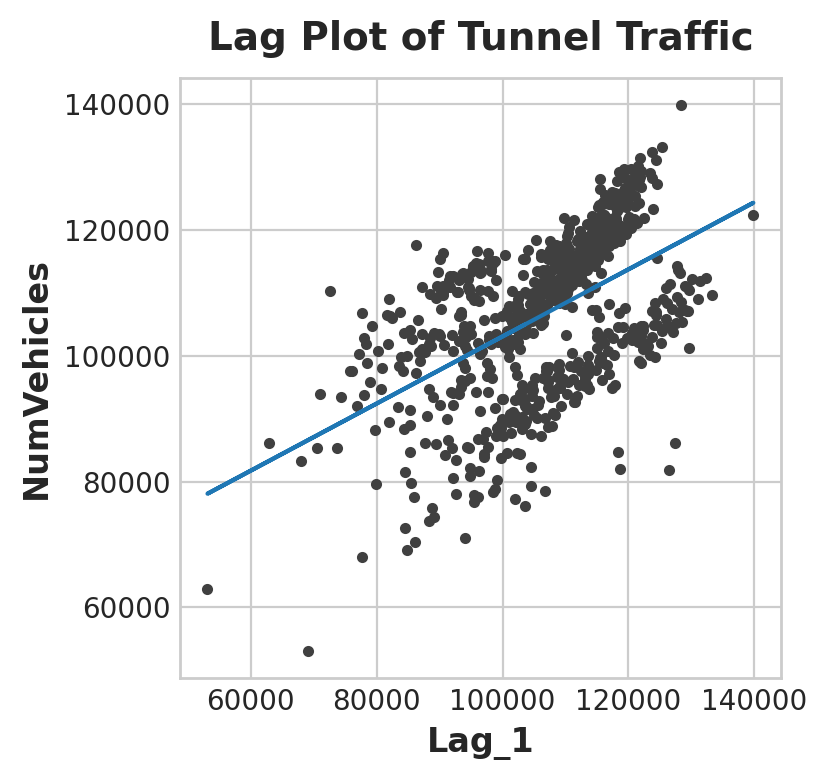

In [68]:

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

In [69]:
y

Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Freq: D, Name: NumVehicles, Length: 747, dtype: int64

In [70]:
y_pred

Day
2003-11-01    104959.778420
2003-11-02    104959.778420
2003-11-03     98838.236169
2003-11-04    103498.816530
2003-11-05    104328.702580
                  ...      
2005-11-12    117279.615389
2005-11-13    105551.412020
2005-11-14    100103.052866
2005-11-15    109559.063408
2005-11-16    110694.893319
Freq: D, Length: 747, dtype: float64

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

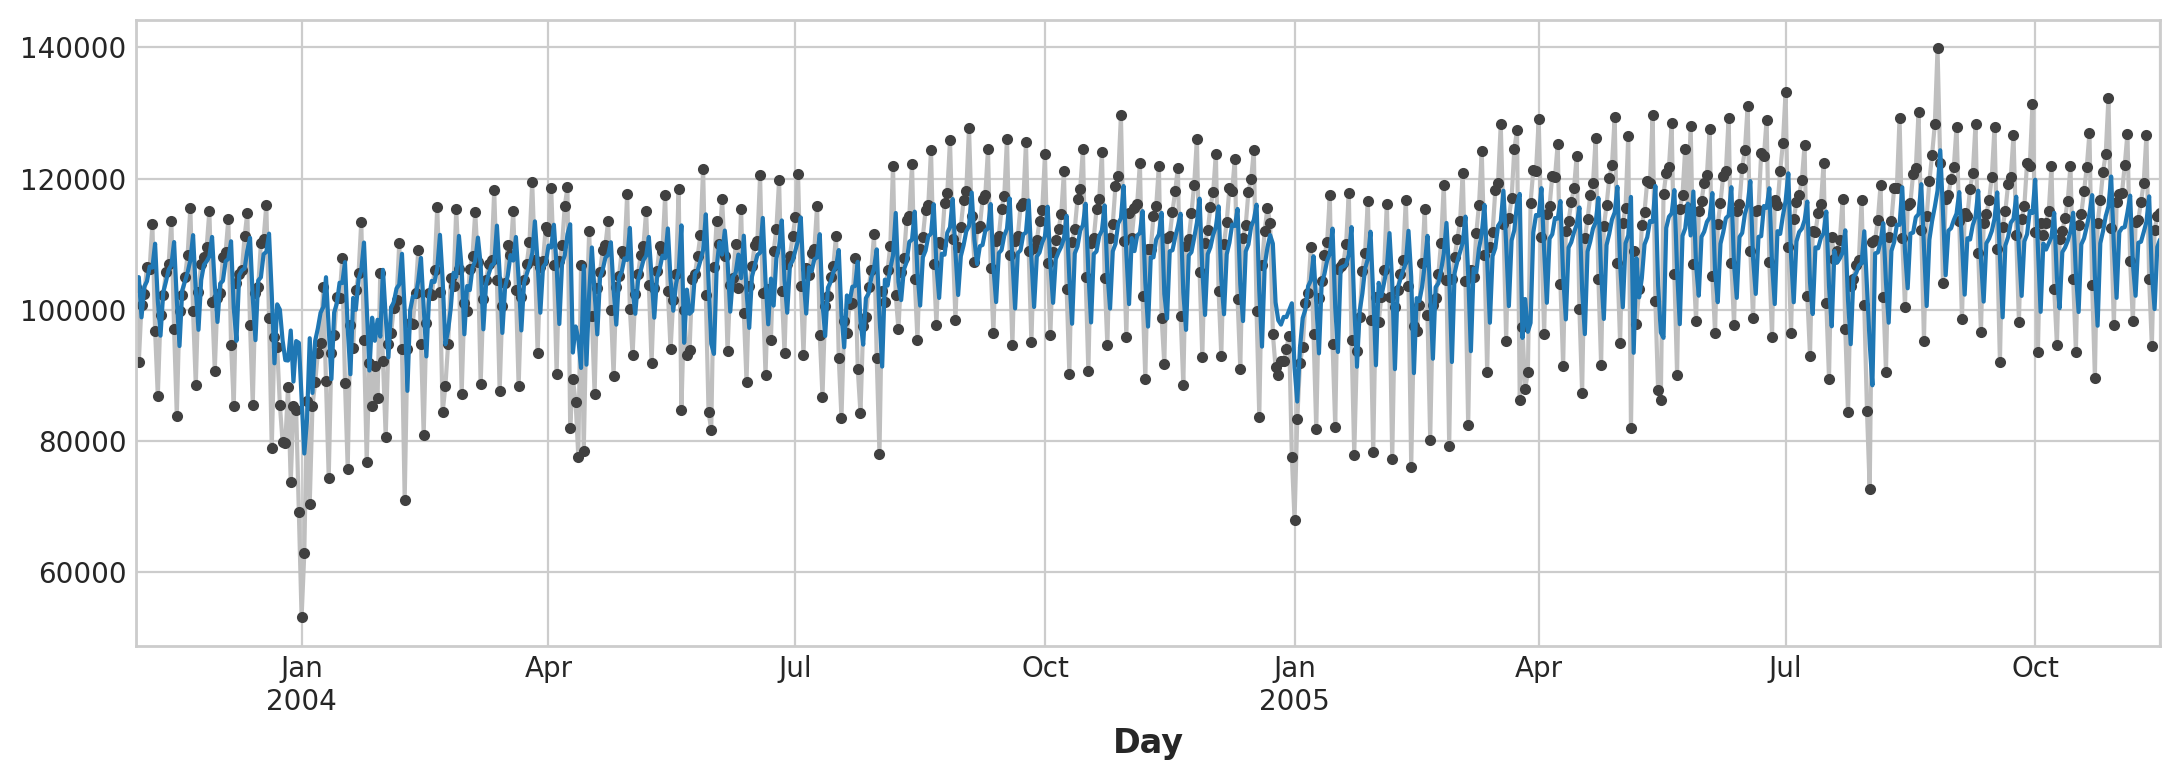

In [71]:
# y是真实值，y_pred是预测值，二者对比着看
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of time-step features and lag features. Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.

# Your Turn #

Move on to the Exercise, where you'll begin [**forecasting Store Sales**](https://www.kaggle.com/kernels/fork/19615998) using the techniques you learned in this tutorial.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*